In [1]:
import glob
import numpy as np 
import time
import math
import random
from scipy import linalg as LA
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.svm import NuSVC
from sklearn.model_selection import train_test_split
from sklearn import metrics
import seaborn as sns
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import statsmodels.api as sm
import matplotlib.pyplot as plt
from termcolor import colored
from matplotlib import colors
import pickle
import os
from sklearn.svm import LinearSVC

## Reading cleaned csv files

### User i is data_1$[i]$ in the following

In [2]:
data_1 = [0] * 57
for i in range(len(data_1)):
    fnames = glob.glob('labeled csv Geolife/'+str(i)+'/*.csv')
    data_1[i] = np.array([np.loadtxt(f, delimiter=',')[1:] for f in fnames])
data_1 = np.array(data_1)

In [3]:
fnames = glob.glob('labeled csv Geolife/**/*.csv')
len(fnames)

3572

### Users are stacked together in data_2 below

In [4]:
data_2 = []
fnames = glob.glob('labeled csv Geolife/**/*.csv')
for f in fnames:
    data_2.append(np.loadtxt(f, delimiter=',')[1:])
data_2 = np.array(data_2)

In [5]:
data_2.shape, data_2[0].shape

((3572,), (371, 4))

In [6]:
A = np.array([len(data_2[i]) for i in range(len(data_2))])
min(A), max(A)

(3, 40392)

### Removing segments with length less than 1e-10 because of numerical precision

In [7]:
data_3 = [0] * len(data_2)
h = 1e-10
c = 0
for i in range(len(data_2)):
    p1 = data_2[i][:-1]
    p2 = data_2[i][1:]
    L = ((p2[:,:2]-p1[:,:2])*(p2[:,:2]-p1[:,:2])).sum(axis =1)
    I = np.where(L > h)[0]
    J = np.where(L < h)[0]
    if len(J) > 0:
        c += 1
    p1 = p1[I]
    p2 = p2[I]
    if len(I) == 0:
        print(i)
    gamma = np.concatenate((p1, p2[-1].reshape(1,4)), 0) 
    if len(gamma) > 0:
        data_3[i] = gamma
    data_3[i] = np.array(data_3[i])
data_3 = np.array(data_3)
c

3182

In [8]:
data_3.shape, data_3[0].shape

((3572,), (360, 4))

In [9]:
A = np.array([len(data_3[i]) for i in range(len(data_3))])
min(A), max(A), np.where(A > 40000)[0]

(2, 40323, array([1380]))

# Partitioning trajectories to less than 20 minutes long

In [10]:
# 24 * 60 * (days_date('1899/12/30 2:50:06') - days_date('1899/12/30 2:20:06')) == 20 min
Time = np.zeros(len(data_3))
for i in range(len(data_3)):
    Time[i] = 24 * 60 * sum(data_3[i][:,2][1:] - data_3[i][:,2][:-1]) # = 20 minutes 
min(Time), max(Time), np.where(Time>2000)

(0.08333337376825511, 2085.283333301777, (array([2940]),))

In [11]:
J = np.where(Time>20)[0]
len(J)

2365

In [12]:
data_3[2940][:,2].shape, Time[2940]

((3451,), 2085.283333301777)

In [13]:
def partition(trajectory):
    trajectories = []
    a = 24 * 60 * sum(trajectory[:,2][1:] - trajectory[:,2][:-1])
    if a <= 20:
        return np.array(trajectory.reshape(1, len(trajectory), 4))
    else: 
        i = 0
        while a > 20:
            j = i + 0
            val = 0
            while val < 20: 
                if i < len(trajectory) - 1:
                    temp = val + 0
                    val += 24 * 60 * (trajectory[:,2][1:][i] - trajectory[:,2][:-1][i])
                    i += 1
                else: 
                    break
            if len(trajectory[j:i-1]) > 0:
                trajectories.append(trajectory[j:i-1])
            a = a - val
        if len(trajectory[i:]) > 0:
            trajectories.append(trajectory[i:])
    return trajectories

In [14]:
# Check to see if partitioning into less than 20 minutes worked correctly
for j in J:
    A = partition(data_3[j])
    B = np.array([24 * 60 * sum(A[i][:,2][1:] - A[i][:,2][:-1]) for i in range(len(A))])
    I = np.where(B > 20)[0]
    if len(I) > 0: 
        print(j)

### data_4 below is the array of trajectories having less than 20 minutes long

In [15]:
data_4 = []
for i in range(len(data_3)):
    A = partition(data_3[i])
    for j in range(len(A)):
        data_4.append(A[j])
data_4 = np.array(data_4)

In [16]:
data_4.shape, data_4[0].shape

((11833,), (360, 4))

In [17]:
I = np.where(np.array([len(data_4[i]) for i in range(len(data_4))]) != 1)[0]
data_4 = data_4[I]
len(data_4)

11751

In [18]:
int1 = np.vectorize(int)
data_5 = []
c = 0
for i in range(len(data_4)):
    if len(set(int1(data_4[i][:,3]))) < 2: 
        data_5.append(data_4[i])
        c += 1
data_5 = np.array(data_5)
c

10039

In [19]:
# a:b
# a is the number of labels in a trajectory
# b is the number of trajectries with a labels
D = {1:10121, 2:1671, 3:39, 4:2, 5:0}

In [20]:
Modes = ['walk', 'bike', 'bus', 'driving', 'train']

# Multi class classification through $v_Q^{\sigma}$

In [21]:
def dist_signed_point(Q, gamma, sigma): 
    
    h = 10e-10
    p1 = gamma[:-1]
    p2 = gamma[1:]
    L = np.sqrt(((p2-p1)*(p2-p1)).sum(axis =1))
    II = np.where(L > h)[0]
    p1 = p1[II]
    p2 = p2[II]
    gamma = np.array(list(p1) + [p2[-1]]) # or use concatination 
    L = np.sqrt(((p2-p1)*(p2-p1)).sum(axis =1)) 
    w = (p1-p2)*(-1,1)/(L * np.ones((2,1))).T
    w[:,[0, 1]] = w[:,[1, 0]]
    
# signed distance to the extended lines of segments
    dist_signed = np.sum(w * (Q.reshape(len(Q),1,2) - p1), axis=2)
    b = dist_signed + 0
    x = abs(b)
    R = (L**2).reshape(-1,1)

# u = argmin points on the extended lines of segments
    u = p1 + ((((np.sum(((Q.reshape(len(Q),1,2) - p1) * (p2 - p1)),axis=2).reshape(len(Q)
                ,-1,1,1) * (p2-p1).reshape(len(p2-p1),1,2))).reshape(len(Q),len(p1),2))/R)

    G = np.sqrt(np.sum((u-p1)*(u-p1), axis=2))
    H = np.sqrt(np.sum((u-p2)*(u-p2), axis=2))
# d1 = distance to start points
    d1 = np.sqrt(np.sum((Q.reshape(len(Q),1,2)-p1)*(Q.reshape(len(Q),1,2)-p1), axis=2))
# d2 = distance to end points
    d2 = np.sqrt(np.sum((Q.reshape(len(Q),1,2)-p2)*(Q.reshape(len(Q),1,2)-p2), axis=2))
    d = np.where(d1 < d2, d1, d2)

    dist_segment = np.where(abs(G + H - L) < np.ones(len(L)) * 2*h, dist_signed, d)

    J2 = [0] * len(Q)
    for i in range(len(Q)): 
        J2[i] = np.where(abs(G + H - L)[i] > 2 * h)[0]
    J2 = np.array(J2, dtype = 'object')
    
    dist_segment_copy = dist_segment + 0
    dist = abs(dist_segment_copy)
    
    dist_from_start_1 = np.sqrt(((Q -p1[0])*(Q -p1[0])).sum(axis =1))
    ds_1 = ((Q -p1[0])*w[0]).sum(axis =1)
    dist_from_start = ds_1 * np.maximum(abs(ds_1), np.sqrt(dist_from_start_1**2 - ds_1**2 + 
                                                        h))/ (dist_from_start_1 + h)

    dist_from_end_1 = np.sqrt(((Q -p2[-1])*(Q -p2[-1])).sum(axis =1))
    de_1 = ((Q -p2[-1])* w[-1]).sum(axis =1)
    dist_from_end = de_1 * np.maximum(abs(de_1), np.sqrt(dist_from_end_1**2 - 
                                                de_1**2 + h))/ (dist_from_end_1+ h)
    
    dist_segment[:,0] = np.where(abs(dist[:,0]- dist_from_start_1)< h**2, 
                                 dist_from_start, dist_segment[:,0]) 
    
    dist_segment[:,-1] = np.where(abs(dist[:,-1]- dist_from_end_1)< h**2, 
                                  dist_from_end, dist_segment[:,-1]) 

    j = np.argmin(dist, axis =1)
    #print("j=", j)
    sign = np.ones(len(Q))
    for k in range(len(Q)): 
        if j[k] in J2[k]: 
            if j[k] == 0 and LA.norm(Q[k] - gamma[0]) < LA.norm(Q[k] - gamma[1]):
                sign[k] = 1
                
            elif j[k] == len(gamma)-2 and LA.norm(Q[k] - gamma[j[k]+1]) < LA.norm(Q[k] - 
                                                                            gamma[j[k]]):
                sign[k] = 1
            elif LA.norm(Q[k] - gamma[j[k]]) < LA.norm(Q[k] - gamma[j[k]+1]): 
                q = 2 * gamma[j[k]] - (gamma[j[k]-1] + gamma[j[k]+1])/2
                sign[k] = np.sign((q-gamma[j[k]]).dot(w[j[k]-1] + w[j[k]]))
            elif LA.norm(Q[k] - gamma[j[k]+1]) <= LA.norm(Q[k] - gamma[j[k]]):
                q = 2 * gamma[j[k]+1] - (gamma[j[k]] + gamma[j[k]+2])/2
                sign[k] = np.sign((q-gamma[j[k]+1]).dot(w[j[k]] + w[j[k]+1]))

    E = dist_segment[np.arange(len(dist_segment)),j] 
    F = dist[np.arange(len(dist)),j] 
    dist_weighted = (1/sigma) * sign * (E.reshape(-1,1) *
                        np.exp(-(F/sigma)**2).reshape(-1,1)).reshape(1,-1)

    return dist_weighted.reshape(len(Q))

In [22]:
# speed calculator (for trajectories of one transportation mode can be used)
def speed(x):
    t = x[:,2][1:] - x[:,2][:-1] + 1e-10
    p1 = x[:,:2][:-1]
    p2 = x[:,:2][1:]
    L = np.sqrt(((p2-p1)*(p2-p1)).sum(axis =1))
    speeds = L/t
    s = [sum(speeds)/len(speeds)]
    return s

In [23]:
# acceleration calculator (for trajectories of one transportation mode can be used)
def acceleration(x):
    t = x[:,2][1:] - x[:,2][:-1] + 1e-10
    p1 = x[:,:2][:-1]
    p2 = x[:,:2][1:]
    L = np.sqrt(((p2-p1)*(p2-p1)).sum(axis =1))
    accelerations = L/t**2
    a = [1e-5 * sum(accelerations)/len(accelerations)]
    return a

In [24]:
Min = np.min([np.min(data_5[i][:,:2], 0) for i in range(len(data_5))], 0)
Max = np.max([np.max(data_5[i][:,:2], 0) for i in range(len(data_5))], 0)
Mean = np.mean([np.mean(data_5[i][:,:2], 0) for i in range(len(data_5))], 0)
Std = np.std([np.std(data_5[i][:,:2], 0) for i in range(len(data_5))], 0)
Min, Max, Mean, Std

(array([  18.250483 , -122.3315333]),
 array([400.16666667, 126.993478  ]),
 array([ 39.53897446, 114.19378311]),
 array([0.10806124, 0.01766428]))

In [25]:
m = 20
Q = np.ones((m,2))

Q[:,0] = 0.5 * np.random.random_sample(m) + Mean[0] + 0.2
Q[:,1] = 0.5 * np.random.random_sample(m) + Mean[1] + 2

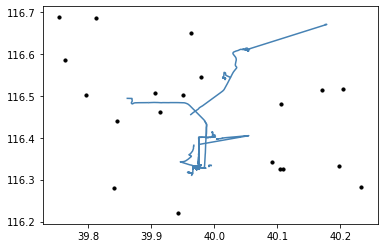

In [26]:
for k in range(100):
    plt.plot(data_5[k][:,0], data_5[k][:,1], color = "steelblue");

plt.scatter(Q[:,0], Q[:,1], s=10, color= 'black');
plt.show()

In [142]:
Q

array([[ 39.7537663 , 116.68683524],
       [ 39.84140089, 116.27917294],
       [ 39.79651471, 116.50250621],
       [ 39.81275612, 116.68660694],
       [ 39.76298334, 116.58486543],
       [ 40.2338415 , 116.28353489],
       [ 39.84525743, 116.43891922],
       [ 39.90620283, 116.5076504 ],
       [ 40.09097358, 116.34098146],
       [ 39.96336842, 116.64988683],
       [ 40.19735203, 116.33345504],
       [ 40.10865532, 116.32585135],
       [ 39.914604  , 116.46040949],
       [ 40.10483436, 116.32450891],
       [ 40.17096568, 116.51379977],
       [ 40.20379651, 116.51727174],
       [ 39.97883564, 116.5453092 ],
       [ 39.94207961, 116.22102075],
       [ 39.95111097, 116.501759  ],
       [ 40.1063385 , 116.47917532]])

In [189]:
start_time = time.time()
sigma = 1000
projected = [0] * len(data_5[:5000]) # in R^20

for i in range(len(data_5[:5000])):
    projected[i] = np.concatenate((dist_signed_point(Q,data_5[i][:,:2], sigma), 
                                   speed(data_5[i]), 
                                   acceleration(data_5[i]),
                                   #data_5[i][0][:2], data_5[i][-1][:2],
                                   [data_5[i][:,3][0]]), axis = 0)
projected = np.array(projected)
print("time =", time.time() - start_time)

time = 15.560288667678833


In [190]:
len(projected), len(projected[0])

(5000, 23)

# Classifiers

In [192]:
CC = [1e3, 1e4, 10, 1e3, 1e4, 1e4, 1e4]
g = [1, 'auto', 1e3, 1e4, 3e4]
number_estimators = [100, 100]
clf0 = [KNeighborsClassifier(n_neighbors=5), "KNN"]
clf1 = [make_pipeline(LinearSVC(dual=False, C=CC[0], tol=1e-5, 
                               class_weight ='balanced', max_iter=1000)), 
        "Linear kernel SVM, C = "+str(CC[0])]
clf2 = [make_pipeline(StandardScaler(), LinearSVC(dual=False, C=CC[0], tol=1e-5, 
                               class_weight ='balanced', max_iter=1000)), 
        "Linear kernel SVM (Standardized), C = "+str(CC[0])]
clf3 = [make_pipeline(StandardScaler(), svm.SVC(C=CC[1], kernel = 'rbf', gamma= g[0], max_iter = 200000)), 
        "Gaussian SVM, C = "+str(CC[1])+", gamma ="+str(g[0])]
clf4 = [make_pipeline(StandardScaler(), svm.SVC(C=CC[2], kernel = 'rbf', gamma= g[1], max_iter = 200000)),
        "Gaussian SVM, C = "+str(CC[2])+", gamma ="+str(g[1])]
clf5 = [make_pipeline(StandardScaler(), svm.SVC(C=CC[3], kernel = 'rbf', gamma= g[2], max_iter = 200000)),
        "Gaussian SVM, C = "+str(CC[3])+", gamma ="+str(g[2])]
clf6 = [make_pipeline(StandardScaler(), svm.SVC(C=CC[4], kernel = 'rbf', gamma= g[3], max_iter = 200000)),
        "Gaussian SVM, C = "+str(CC[4])+", gamma ="+str(g[3])]
clf7 = [make_pipeline(StandardScaler(), svm.SVC(C=CC[5], kernel = 'rbf', gamma= g[4], max_iter = 200000)),
        "Gaussian SVM, C = "+str(CC[5])+", gamma ="+str(g[4])]
clf8 = [make_pipeline(StandardScaler(), svm.SVC(C=CC[6], kernel = 'poly',  degree=10, max_iter = 400000)),
        "Poly kernel SVM, C = "+str(CC[6])+", deg=10"]
#clf8 = [LogisticRegression(solver='lbfgs'), "Logistic Regression"]
clf9 = [DecisionTreeClassifier(), "Decision Tree"]
clf10 = [RandomForestClassifier(n_estimators=number_estimators[0]), 
         "RandomForestClassifier, n="+str(number_estimators[0])]
clf11 = [AdaBoostClassifier(n_estimators= number_estimators[1],learning_rate=1), 
         "AdaBoost, n="+str(number_estimators[1])]

clf = [clf0, clf1, clf2, clf3, clf4, clf5, clf6, clf7, clf8, clf9, clf10, clf11]
classifs = [item[0] for item in clf]
keys = [item[1] for item in clf]

# Classification

In [193]:
def classification(Data, num_trials = 10, classifiers = clf):

    Start_time = time.time()
    models = [item[0] for item in classifiers]
    keys = [item[1] for item in classifiers]
    r = len(classifiers)
    train_error_mean = np.zeros(r)
    test_error_mean = np.zeros(r)
    test_error_std = np.zeros(r)
    train_error_list = np.zeros((r, num_trials,)) 
    test_error_list = np.zeros((r, num_trials))

    for s in range(num_trials):
        Start_time_1 = time.time()

        X_train, X_test, y_train, y_test = train_test_split(Data[:,:-1], Data[:,-1], 
                                                            test_size=0.3)
        I = np.arange(len(X_train))
        random.shuffle(I)
        X = X_train[I]
        y = y_train[I]

        J = np.arange(len(X_test))
        random.shuffle(J)
        data_test = X_test[J]
        labels_test = y_test[J]
        
        for k in range(r):            
            model = models[k]

            #Train the model using the training sets
            model.fit(X, y)

            #Predict the response for test dataset
            y_pred = model.predict(X_test)
            er = 1 - metrics.accuracy_score(y_test, y_pred)
            test_error_list[k][s] = er

            X_pred = model.predict(X)
            err = 1 - metrics.accuracy_score(y, X_pred)
            train_error_list[k][s] = err

        #print('time for step', s, time.time() - Start_time_1)

    for k in range(r):
        train_error_mean[k] = np.mean(train_error_list[k])
        test_error_mean[k] = np.mean(test_error_list[k])
        test_error_std[k] = np.std(test_error_list[k])

    print('total time =', time.time() - Start_time)
    
    Dic = {}

    for k in range(len(keys)): 
        Dic[k] = [keys[k], np.round(train_error_mean[k], decimals = 4), 
                    np.round(test_error_mean[k], decimals = 4),
                    np.round(test_error_std[k], decimals = 4)]

    pdf = pd.DataFrame.from_dict(Dic, orient='index', columns=['Classifier','Train Error', 
                                                               'Test Error', 'Std Error'])
    
    return pdf

In [194]:
projected = projected[:5000]
Mean = np.mean(projected[:,:-1], 0)
Std = np.std(projected[:,:-1], 0)
norm_projected = (projected[:,:-1] - Mean)/Std
normalized_projected = np.concatenate((norm_projected, projected[:,-1].reshape(-1,1)), 1)
normalized_projected.shape

(5000, 23)

In [85]:
print("With speed and acceleration added")
print("sigma =", sigma)
classification(normalized_projected, num_trials = 1, classifiers = clf)

With speed and acceleration added
sigma = 0.1
total time = 19.073884963989258


,Classifier,Train Error,Test Error,Std Error
0,KNN,0.3103,0.4247,0.0
1,"Linear kernel SVM, C = 1000.0",0.5760,0.6073,0.0
2,"Linear kernel SVM (Standardized), C = 1000.0",0.5743,0.6060,0.0
3,"Gaussian SVM, C = 10000.0, gamma =1",0.0943,0.4687,0.0
4,"Gaussian SVM, C = 10, gamma =auto",0.3646,0.4673,0.0
5,"Gaussian SVM, C = 1000.0, gamma =1000.0",0.0577,0.6007,0.0
6,"Gaussian SVM, C = 10000.0, gamma =10000.0",0.0543,0.6100,0.0
7,"Gaussian SVM, C = 10000.0, gamma =30000.0",0.0537,0.6120,0.0
8,"Poly kernel SVM, C = 10000.0, deg=10",0.2560,0.4893,0.0
9,Decision Tree,0.0040,0.3627,0.0


In [82]:
print("With speed and acceleration added")
print("sigma =", sigma)
classification(normalized_projected, num_trials = 1, classifiers = clf)

With speed and acceleration added
sigma = 1000


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=200000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


total time = 30.25049090385437


,Classifier,Train Error,Test Error,Std Error
0,KNN,0.3849,0.5380,0.0
1,"Linear kernel SVM, C = 1000.0",0.6074,0.6360,0.0
2,"Linear kernel SVM (Standardized), C = 1000.0",0.6097,0.6353,0.0
3,"Gaussian SVM, C = 10000.0, gamma =1",0.4654,0.5180,0.0
4,"Gaussian SVM, C = 10, gamma =auto",0.6971,0.7233,0.0
5,"Gaussian SVM, C = 1000.0, gamma =1000.0",0.0380,0.4913,0.0
6,"Gaussian SVM, C = 10000.0, gamma =10000.0",0.0009,0.5313,0.0
7,"Gaussian SVM, C = 10000.0, gamma =30000.0",0.0006,0.5220,0.0
8,"Poly kernel SVM, C = 10000.0, deg=10",0.7357,0.7400,0.0
9,Decision Tree,0.0000,0.3447,0.0


In [78]:
print("With speed added")
print("sigma =", sigma)
classification(normalized_projected, num_trials = 100, classifiers = [clf10])

With speed added
sigma = 1000
total time = 118.66120195388794


,Classifier,Train Error,Test Error,Std Error
0,"RandomForestClassifier, n=100",0.0,0.2525,0.0111


In [36]:
print("With normalized projected data")
print("With speed added")
print("sigma =", sigma)
classification(projected, num_trials = 1, classifiers = clf)

With normalized projected data
With speed added
sigma = 0.1
time for step 0 17.321376085281372
total time = 17.322158813476562


,Classifier,Train Error,Test Error,Std Error
0,KNN,0.2560,0.3567,0.0
1,"Linear kernel SVM, C = 1000.0",0.6509,0.6840,0.0
2,"Linear kernel SVM (Standardized), C = 1000.0",0.6443,0.6753,0.0
3,"Gaussian SVM, C = 10000.0, gamma =1",0.0751,0.4447,0.0
4,"Gaussian SVM, C = 10, gamma =auto",0.3531,0.4667,0.0
5,"Gaussian SVM, C = 1000.0, gamma =1000.0",0.0531,0.6213,0.0
6,"Gaussian SVM, C = 10000.0, gamma =10000.0",0.0509,0.6273,0.0
7,"Gaussian SVM, C = 10000.0, gamma =30000.0",0.0509,0.6327,0.0
8,"Poly kernel SVM, C = 10000.0, deg=10",0.2343,0.5127,0.0
9,Decision Tree,0.0000,0.3573,0.0


In [42]:
print("With normalized projected data")
print("With speed added")
print("sigma =", sigma)
classification(projected, num_trials = 1, classifiers = clf)

With normalized projected data
With speed added
sigma = 1000


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=200000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


time for step 0 25.153813123703003


,Classifier,Train Error,Test Error,Std Error
0,KNN,0.2937,0.3767,0.0
1,"Linear kernel SVM, C = 1000.0",0.7106,0.7320,0.0
2,"Linear kernel SVM (Standardized), C = 1000.0",0.6714,0.6833,0.0
3,"Gaussian SVM, C = 10000.0, gamma =1",0.5486,0.6047,0.0
4,"Gaussian SVM, C = 10, gamma =auto",0.7031,0.7207,0.0
5,"Gaussian SVM, C = 1000.0, gamma =1000.0",0.0389,0.5280,0.0
6,"Gaussian SVM, C = 10000.0, gamma =10000.0",0.0006,0.5260,0.0
7,"Gaussian SVM, C = 10000.0, gamma =30000.0",0.0006,0.5373,0.0
8,"Poly kernel SVM, C = 10000.0, deg=10",0.7086,0.7247,0.0
9,Decision Tree,0.0000,0.3467,0.0


In [47]:
print("With speed added")
print("sigma =", sigma)
classification(normalized_projected, num_trials = 100, classifiers = [clf10])

With speed added
sigma = 1000


,Classifier,Train Error,Test Error,Std Error
0,"RandomForestClassifier, n=100",0.0,0.2538,0.01


# Multi class classification through $v_Q$

In [161]:
def old_dist(Q, gamma):
    
    p2 = gamma[1:]
    p1 = gamma[:-1]
    L = np.sqrt(((p2-p1)*(p2-p1)).sum(axis =1))
    II = np.where(L>10e-8)[0]
    L = L[II]
    p1 = p1[II]
    p2 = p2[II]
    w = (p1-p2)*(-1,1)/(L*np.ones((2,1))).T
    w[:,[0, 1]] = w[:,[1, 0]]
    
    dist_dot = np.sum(w * (Q.reshape(len(Q),1,2) - p1), axis=2)
    
    x = abs(dist_dot.copy())
    R = (L**2).reshape(-1,1)
    u = p1 + ((((np.sum(((Q.reshape(len(Q),1,2) - p1) * (p2 - p1)),axis=2).reshape(len(Q)
                ,-1,1,1) * (p2-p1).reshape(len(p2-p1),1,2))).reshape(len(Q),len(p1),2))/R)
    
    G = np.sqrt(np.sum((u-p1)*(u-p1), axis=2))
    H = np.sqrt(np.sum((u-p2)*(u-p2), axis=2))
    d1 = np.sqrt(np.sum((Q.reshape(len(Q),1,2)-p1)*(Q.reshape(len(Q),1,2)-p1), axis=2))
    d2 = np.sqrt(np.sum((Q.reshape(len(Q),1,2)-p2)*(Q.reshape(len(Q),1,2)-p2), axis=2))

    dist = np.where(abs(G + H - L) < np.ones(len(L)) * (10e-8), x, np.minimum(d1, d2))

    j = np.argmin(dist, axis =1)
    dist_weighted = dist[np.arange(len(dist)),j] # np.choose(j, dist.T) 
    
    return dist_weighted.reshape(len(Q)) # (w[j],dist[j],dist_dot[j],dist_weighted)

In [185]:
start_time = time.time()
proj = [0] * len(data_5[:5000]) # in R^20

for i in range(len(data_5[:5000])):
    proj[i] = np.concatenate((old_dist(Q,data_5[i][:,:2]), 
                              speed(data_5[i]), 
                              acceleration(data_5[i]),
                              #data_5[i][0][:2], data_5[i][-1][:2],
                              [data_5[i][:,3][0]]), axis = 0)
proj = np.array(proj)
print("time =", time.time() - start_time)

time = 7.643392086029053


In [188]:
Mean1 = np.mean(proj[:,:-1], 0)
Std1 = np.std(proj[:,:-1], 0)
norm_proj = (proj[:,:-1] - Mean1)/Std1
normalized_proj = np.concatenate((norm_proj, proj[:,-1].reshape(-1,1)), 1)
normalized_proj.shape

(5000, 23)

In [76]:
print("With normalized proj data")
print("With speed added")
classification(normalized_proj, num_trials = 100, classifiers = [clf0, clf6, clf9, clf10])

With normalized proj data
With speed added


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=200000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=200000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=200000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=200000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 521.0680160522461


,Classifier,Train Error,Test Error,Std Error
0,KNN,0.2026,0.2768,0.0107
1,"Gaussian SVM, C = 10000.0, gamma =10000.0",0.0978,0.2759,0.0121
2,Decision Tree,0.0000,0.2662,0.0118
3,"RandomForestClassifier, n=100",0.0000,0.1975,0.0086


In [77]:
print("With speed added")
classification(proj, num_trials = 100, classifiers =  [clf0, clf6, clf9, clf10])

With speed added


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=200000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=200000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=200000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=200000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 526.766608953476


,Classifier,Train Error,Test Error,Std Error
0,KNN,0.2168,0.2999,0.0101
1,"Gaussian SVM, C = 10000.0, gamma =10000.0",0.0983,0.2752,0.0119
2,Decision Tree,0.0000,0.2628,0.0108
3,"RandomForestClassifier, n=100",0.0000,0.1960,0.0083


In [73]:
print("With normalized proj data")
print("With speed and acceleration added")
classification(normalized_proj, num_trials = 100, classifiers = [clf0, clf9, clf10])

With normalized proj data
With speed and acceleration added
total time = 148.50016593933105


,Classifier,Train Error,Test Error,Std Error
0,KNN,0.2026,0.2785,0.0101
1,Decision Tree,0.0000,0.2668,0.0108
2,"RandomForestClassifier, n=100",0.0000,0.1967,0.0103


# Results that are reported:

In [72]:
print("With speed and acceleration added")
classification(proj, num_trials = 100, classifiers = [clf0, clf9, clf10])

With speed and acceleration added
total time = 162.82137989997864


,Classifier,Train Error,Test Error,Std Error
0,KNN,0.1883,0.2551,0.0102
1,Decision Tree,0.0000,0.2438,0.0109
2,"RandomForestClassifier, n=100",0.0000,0.1770,0.0089


In [88]:
print("With speed and acceleration added")
classification(proj, num_trials = 100, classifiers = [clf6])

With speed and acceleration added


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=200000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=200000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=200000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=200000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 376.8989272117615


,Classifier,Train Error,Test Error,Std Error
0,"Gaussian SVM, C = 10000.0, gamma =10000.0",0.099,0.2726,0.0112
